### Import packages

In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(Rtsne)
library(data.table)
library(irlba)
library(umap)
library(ggplot2)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



### Preprocess

`bsub < count_reads_peaks_erisone.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [3]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 491437   2034

In [5]:
df_regions = read.csv("../../input/GSE96769_PeakFile_20160207.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 491437     14

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_10279_10779"   "chr1_13252_13752"   "chr1_16019_16519"  
[4] "chr1_29026_29526"   "chr1_96364_96864"   "chr1_115440_115940"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [11]:
head(datafr)

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-3,BM1077-CLP-Frozen-160106-36,BM1077-CLP-Frozen-160106-42,BM1077-CLP-Frozen-160106-44,BM1077-CLP-Frozen-160106-50,⋯,singles-PB1022-mono-160128-81,singles-PB1022-mono-160128-82,singles-PB1022-mono-160128-83,singles-PB1022-mono-160128-84,singles-PB1022-mono-160128-85,singles-PB1022-mono-160128-86,singles-PB1022-mono-160128-89,singles-PB1022-mono-160128-90,singles-PB1022-mono-160128-95,singles-PB1022-mono-160128-96
chr1_10279_10779,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_13252_13752,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_16019_16519,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_29026_29526,0,0,0,0,0,0,0,0,2,0,⋯,0,0,2,0,2,3,0,0,0,0
chr1_96364_96864,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
chr1_115440_115940,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
dim(datafr)

[1] 491437   2034

In [13]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [14]:
run_pca <- function(mat,num_pcs=50,remove_first_PC=FALSE,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    if(remove_first_PC){
        sk_diag[1,1] = 0
        SVD_vd = (sk_diag %*% t(SVD$v))[2:num_pcs,]
    }else{
        SVD_vd = sk_diag %*% t(SVD$v)
    }
    return(SVD_vd)
}


elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

filter_peaks <- function (datafr,cutoff = 0.01){
    binary_mat = as.matrix((datafr > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    num_cells_ncounted = Matrix::rowSums(binary_mat)
    ncounts = binary_mat[num_cells_ncounted >= dim(binary_mat)[2]*cutoff,]
    ncounts = ncounts[rowSums(ncounts) > 0,]    
    
    options(repr.plot.width=4, repr.plot.height=4)
    hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
    abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(binary_mat)[2]*cutoff])),lwd=2,col="indianred")
#     hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
    datafr_filtered = datafr[rownames(ncounts),]
    return(datafr_filtered)
}

### Obtain Feature Matrix

In [15]:
start_time <- Sys.time()

In [16]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

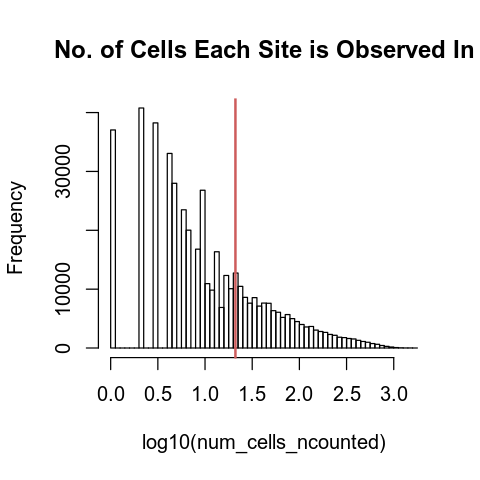

In [17]:
datafr_filtered <- filter_peaks(datafr)

In [18]:
dim(datafr_filtered)

[1] 135202   2034

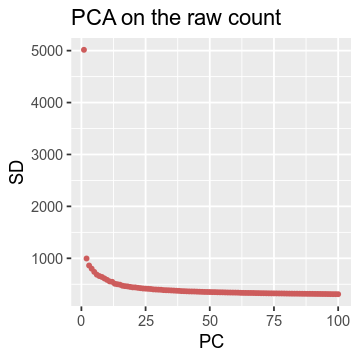

In [19]:
p_elbow_control <- elbow_plot(datafr_filtered,num_pcs = 100, title = 'PCA on the raw count')
p_elbow_control

In [20]:
fm_control = run_pca(datafr_filtered,num_pcs = 50)

In [21]:
dim(fm_control)
fm_control[1:3,1:3]

[1]   50 2034

-18.245435,-16.3633746,-15.79409738
2.451703,-0.4154084,-0.05161358
-4.566364,1.3013334,1.70120044


In [22]:
end_time <- Sys.time()

In [23]:
end_time - start_time

Time difference of 1.586338 mins

In [24]:
colnames(fm_control) = colnames(datafr)
rownames(fm_control) = paste('PC',1:dim(fm_control)[1])
dim(fm_control)

[1]   50 2034

In [25]:
all(colnames(fm_control) == rownames(metadata))

[1] TRUE

In [26]:
saveRDS(fm_control, file = '../../output/feature_matrices/FM_Control_buenrostro2018bulkpeaks.rds')

### Downstream Analysis

In [27]:
set.seed(0)
tsne_control = Rtsne(t(fm_control),pca=F)

In [28]:
library(RColorBrewer)

In [29]:
plot.tsne <- function(x, labels,
         main="A tSNE visualization",n=20,
         pad=0.1, cex=0.65, pch=19, add=FALSE, legend.suffix="",
         cex.main=1, cex.legend=1) {
  qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
  col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
  layout = x
  
  xylim = range(layout)
  xylim = xylim + ((xylim[2]-xylim[1])*pad)*c(-0.5, 0.5)
  if (!add) {
    par(mar=c(0.2,0.7,1.2,0.7), ps=10)
    plot(xylim, xylim, type="n", axes=F, frame=F)
    rect(xylim[1], xylim[1], xylim[2], xylim[2], border="#aaaaaa", lwd=0.25)  
  }
  points(layout[,1], layout[,2], col=col_vector[as.integer(labels)],
         cex=cex, pch=pch)
  mtext(side=3, main, cex=cex.main)

  labels.u = unique(labels)
  legend.pos = "topright"
  legend.text = as.character(labels.u)
  if (add) {
    legend.pos = "bottomright"
    legend.text = paste(as.character(labels.u), legend.suffix)
  }
  legend(legend.pos, legend=legend.text,
         col=col_vector[as.integer(labels.u)],
         bty="n", pch=pch, cex=cex.legend)
}

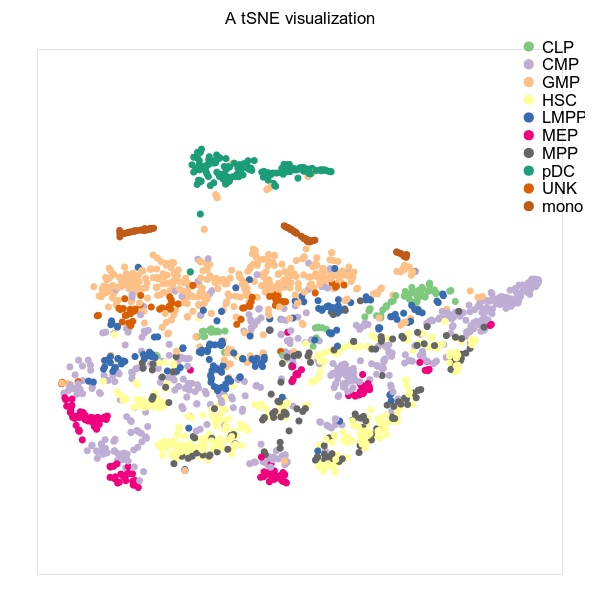

In [30]:
options(repr.plot.width=5, repr.plot.height=5)
plot.tsne(tsne_control$Y,as.factor(metadata[,'label']))

In [31]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_sciATAC/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-2 ggplot2_3.1.1      umap_0.2.0.0       irlba_2.3.2       
[5] Rtsne_0.15         proxy_0.4-22       Matrix_1.2-17      data.table_1.12.2 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       compiler_3.5.1   pillar_1.3.1     plyr_1.8.4      


In [32]:
save.image(file = 'Control_buenrostro2018bulkpeaks.RData')